# Causeme

In [1]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from src.models import NAVAR, TAMCaD, TAMCaD_UA
from src.training import train_model, train_test_split
from tqdm.notebook import trange, tqdm
from src.utils import load_data, write_causeme_predictions
from src.eval import plot_heatmaps

In [2]:
name = 'nonlinear-VAR_N-3_T-300'
dataset = load_data('causeme', name).as_dict()
print({k: v.shape if isinstance(v, torch.Tensor) else v for k, v in dataset.items()})

{'name': 'nonlinear-VAR_N-3_T-300', 'data': torch.Size([200, 3, 300])}


[train] loss=0.58 [test] loss=0.66: 100%|████████████████████████████████████████████| 900/900 [00:37<00:00, 24.11it/s]


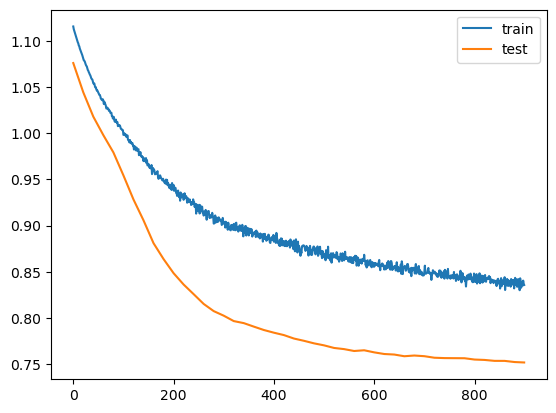

dict_keys(['train_artifacts', 'test_artifacts', 'model_params', 'train_data', 'test_data', 'train_metrics', 'test_metrics'])

In [3]:
params = {
    'model_type': TAMCaD_UA, 
    'n_ensembles': 30,
    'gamma': 0.0,
    'lambda1': 0.1,
    'hidden_dim': 8, 
    'weight_sharing': True, 
    'epochs': 900,
    'dropout': 0.2,
    'experiment_name': 'causeme',
    'lr': 1e-3,
    'weight_decay': 1e-8,
    'test_size': 0.3,
    'kernel_size': 2,
    'n_blocks': 2,
    'n_layers': 2,
    'use_positional_embedding': False
}

all_datasets = dataset['data'].size(0)
#all_datasets = 5

all_results = []
for i in range(all_datasets):
    all_results.append([])
    for j in range(1):
        all_results[-1].append(train_model(
            experiment_run=name,
            dataset={'name': dataset['name'], 'data':dataset['data'][i:i+1]},
            **params))

plt.plot(*all_results[0][0]['train_metrics']['loss'], label='train')
plt.plot(*all_results[0][0]['test_metrics']['loss'], label='test')
plt.legend()
plt.show()
all_results[0][0].keys()

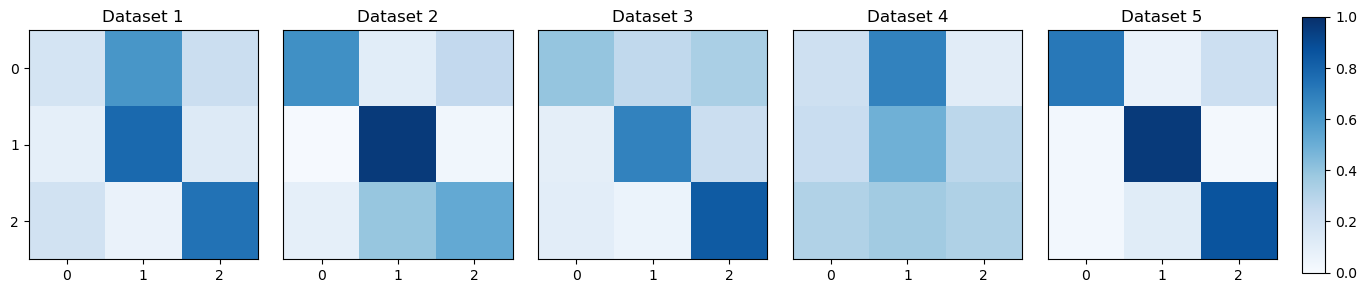

In [4]:
matrices = []
for i, results_list in enumerate(all_results[:5]):
    matrices += [r['test_artifacts']['matrix'] for r in results_list]
plot_heatmaps(*matrices, names=[f"Dataset {i+1}" for i in range(len(matrices))])
fig = plt.gcf()
fig.set_size_inches(14, 3, forward=True)
plt.savefig(f'{name}_heatmap.png', dpi=200)
plt.show()

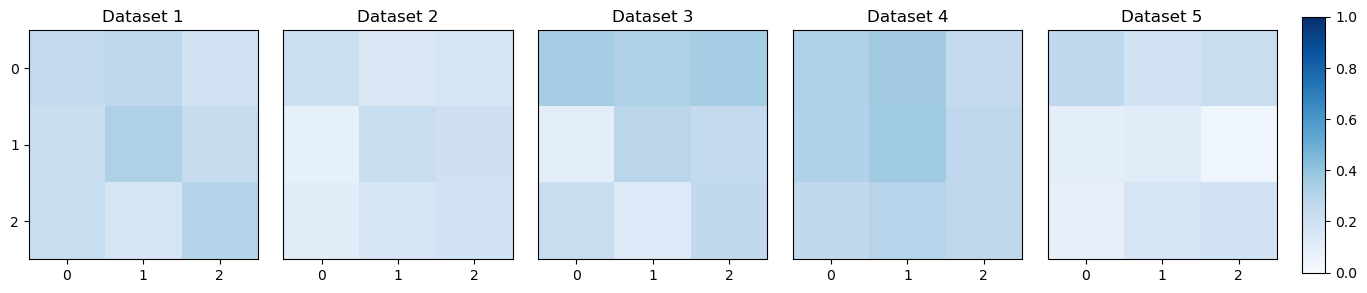

In [5]:
matrices = []
for i, results_list in enumerate(all_results[:5]):
    matrices += [r['test_artifacts']['matrix_ep'] for r in results_list]
plot_heatmaps(*matrices, names=[f"Dataset {i+1}" for i in range(len(matrices))])
fig = plt.gcf()
fig.set_size_inches(14, 3, forward=True)
plt.savefig(f'{name}_heatmap_ep.png', dpi=200)
plt.show()

In [6]:
scores = torch.stack([r[0]['test_artifacts']['matrix'] for r in all_results]).transpose(-1, -2)
print(scores.shape)
write_causeme_predictions('TAMCaD_UA', name, scores, hidden_dim=params['hidden_dim'], type='UA')

torch.Size([200, 3, 3])


'C:\\Users\\mauri\\PycharmProjects\\temporal-causal-discovery\\outputs\\artifacts\\TAMCaD_UA_nonlinear-VAR_N-3_T-300_28566b4c.json.bz2'